## Prepare a bathymetry (Version 0) for MITgcm testing

From GEBCO 2023 gridded data, bounded by N 32.0, S 31.6, W -117.1, E -116.6.

Cut at 1400 m, removed mount on SW corner, flattened bathy at boundaries and prepared for MITgcm reading. May need some smoothing but let's try this first.

Low res, pretty much as it comes form  GEBCO (~0.004 deg or ~380 m).

$$nx = 128 \text{ grid points } \\ 
ny = 96  \text{ grid points }$$

In [1]:
import cmocean as cmo
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import scipy.interpolate as sci_interp
import xarray as xr

In [2]:
filename = '/Users/Karina/Research/Canyons/internalWaves/data/bathy/GEBCO_03_Jun_2023_b0c4bc49ccad/gebco_2023_n32.3_s31.4_w-117.379_e-116.5.nc'
dat = xr.open_dataset(filename)
#dat

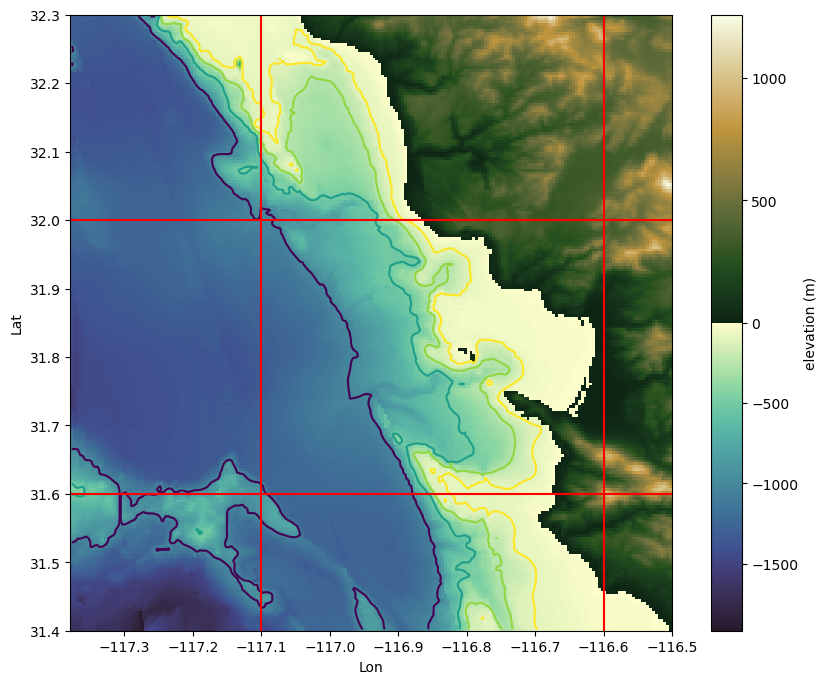

Levels are: yellow -100 m, -250,-500, purple -1000 m


In [3]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

norm = TwoSlopeNorm(vmin=dat.elevation.min(), vcenter=0, vmax=dat.elevation.max())
pc = ax.pcolormesh(dat.lon, dat.lat, dat.elevation,
                   norm=norm, cmap=cmo.cm.topo)
plt.colorbar(pc, label='elevation (m)')
cn = ax.contour(dat.lon, dat.lat, dat.elevation, levels=[-1000,-500,-250,-100])

ax.axhline(32.0, color='r')
ax.axhline(31.6, color='r')
ax.axvline(-117.1, color='r')
ax.axvline(-116.6, color='r')

ax.set_aspect('equal')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
plt.show()
print('Levels are: yellow -100 m, -250,-500, purple -1000 m')

Crop:

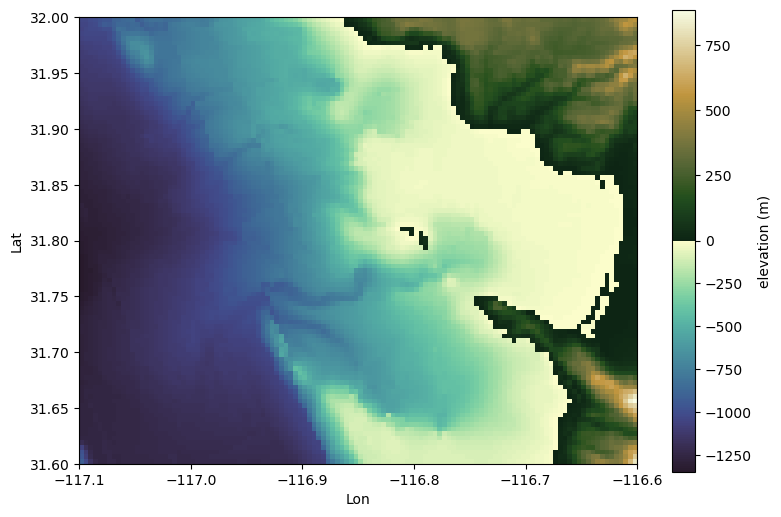

(96, 120)


In [4]:
# define bounds of new domain
ini_lon = -117.1
end_lon = -116.6
ini_lat = 31.6
end_lat = 32.0

# crop arrays for new domain (nd)
lon_nd = dat.lon.sel(lon=slice(ini_lon,end_lon))
lat_nd = dat.lat.sel(lat=slice(ini_lat,end_lat))
ele_nd = dat.elevation.sel(lon=slice(ini_lon,end_lon),lat=slice(ini_lat,end_lat))

# Plot
fig, ax = plt.subplots(1,1, figsize=(9,6))
norm = TwoSlopeNorm(vmin=ele_nd.min(), vcenter=0, vmax=ele_nd.max())
pc = ax.pcolormesh(lon_nd, lat_nd, ele_nd,
                   norm=norm, cmap=cmo.cm.topo)
plt.colorbar(pc, label='elevation (m)')

ax.set_aspect('equal')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
plt.show()

print(np.shape(ele_nd))

1) Make bathymetry into desired gridsize by interpolting.
2) make elevation above sea level be equal to 0 (I don't know if this is necessary, actually) 

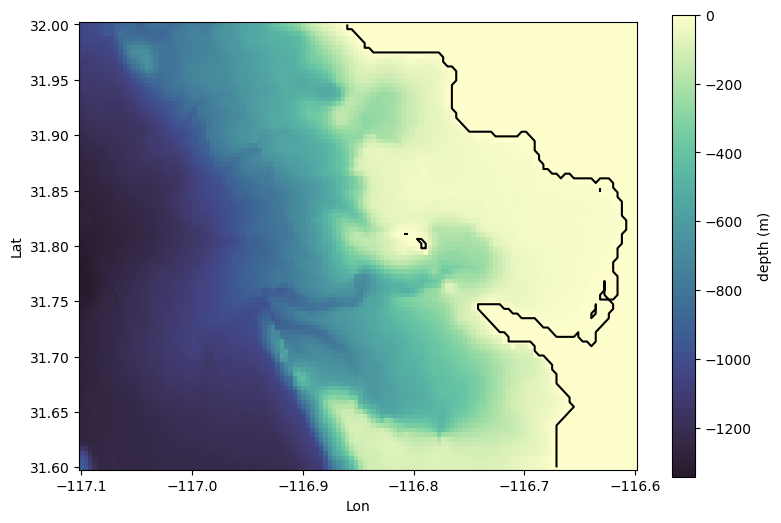

In [5]:
# Choose grid size (I'll make it similar to the number of grid points in ele_nd above)
# to have nice numbers to fit into tiles and processors 
nx = 128
ny = 96

lon_vect = np.round(np.linspace(ini_lon,end_lon,nx), decimals=5)
lat_vect = np.round(np.linspace(ini_lat,end_lat,ny), decimals=5)

f_interp = sci_interp.interp2d(lon_nd, lat_nd, ele_nd)
bathy = f_interp(lon_vect,lat_vect)

# This is our interpolated bathymetry
bathy = np.where(bathy>0, 0, bathy)

# Plot
fig, ax = plt.subplots(1,1, figsize=(9,6))
pc = ax.pcolormesh(lon_vect, lat_vect, bathy,
                   cmap=cmo.cm.deep_r)
plt.colorbar(pc, label='depth (m)')
cn = ax.contour(lon_vect, lat_vect, -bathy, levels=[1E-5], colors='k')
ax.set_aspect('equal')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
plt.show()

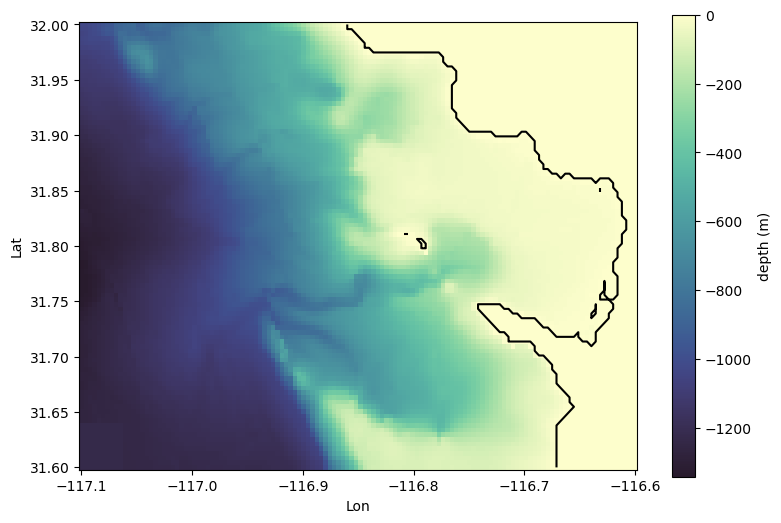

In [6]:
# Remove little bulge in SW corner: replace first 10 cells en each direction 
# with mean depth in the first 20 cells en each direction
bathy[:10,:10] = np.nanmean(bathy[:20,:20])

# Plot
fig, ax = plt.subplots(1,1, figsize=(9,6))
pc = ax.pcolormesh(lon_vect, lat_vect, bathy,
                   cmap=cmo.cm.deep_r)
plt.colorbar(pc, label='depth (m)')
cn = ax.contour(lon_vect, lat_vect, -bathy, levels=[1E-5], colors='k')
ax.set_aspect('equal')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
plt.show()

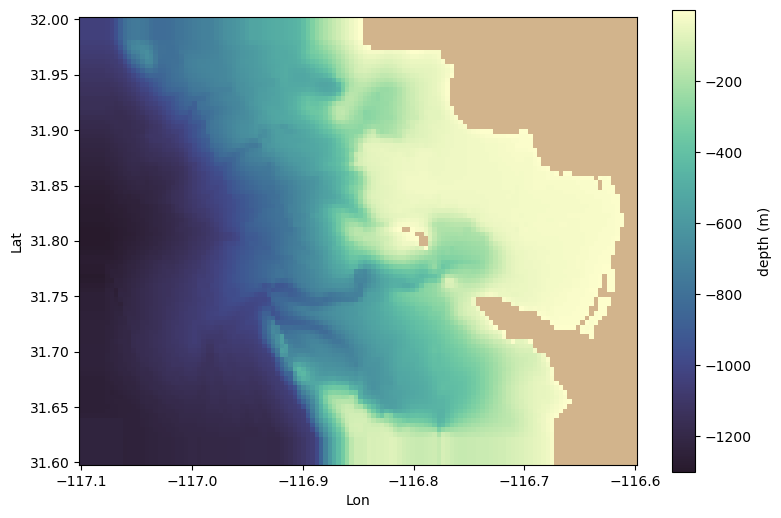

In [7]:
# Flatten out bottom at 1300 m
bathy[bathy < -1300] = -1300

# Flatten bathymetry perpendicular to boundaries (for numerical stability)
for ii in range(5):
    bathy[:,ii] = bathy[:,5]
for ii in range(5):
    bathy[ii,:] = bathy[5,:]
    bathy[-1-ii,:] = bathy[-5,:]

# Plot w/ mask
fig, ax = plt.subplots(1,1, figsize=(9,6))
ax.set_facecolor('tan')
pc = ax.pcolormesh(lon_vect, lat_vect, np.ma.masked_where(bathy==0, bathy),
                   cmap=cmo.cm.deep_r)
plt.colorbar(pc, label='depth (m)')
ax.set_aspect('equal')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')

plt.show()

### Save binary file

In [8]:
# Build grid spacing vectors dx and dy 
delx = lon_vect[1:]-lon_vect[:-1]
dely = lat_vect[1:]-lat_vect[:-1]
dx = np.append(delx, [delx[-1]], axis=0) # This is not the best way to do this
dy = np.append(dely, [dely[-1]], axis=0)

In [9]:
# Check dy and dx (these go in the data file)
print(f'',dy[0], dy[1])
print(f'',dx[0], dx[1])

 0.004209999999996938 0.004210000000000491
 0.003940000000000055 0.00392999999999688


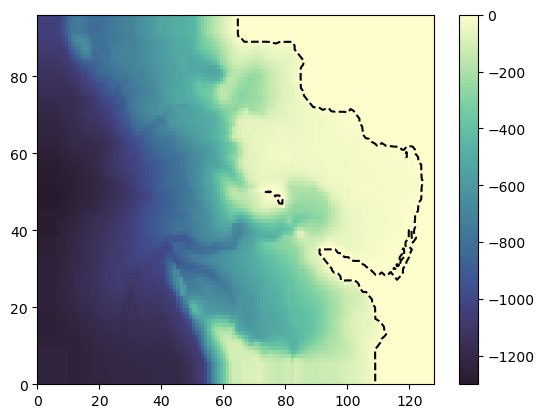

In [10]:
pathname = '/Users/Karina/Tools/MITgcm-master/verification/internal_wave_BTS/input/'
bathy_fname = pathname+'domain0_128x96_BTS_bat.bin'
dx_fname = pathname+'domain0_128x96_BTS_dx.bin'
dy_fname = pathname+'domain0_128x96_BTS_dy.bin'

dt = np.dtype('>f8')  # float 64 big endian

fileobj = open(dx_fname,mode='wb')
dx.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(dy_fname, mode='wb')
dy.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(bathy_fname, mode='wb')
dd=bathy
dd.astype(dt).tofile(fileobj,"")
fileobj.close()

plt.pcolor(dd, cmap=cmo.cm.deep_r)
plt.colorbar()
plt.contour(dd, levels=[-1,0], colors='k')
plt.show()

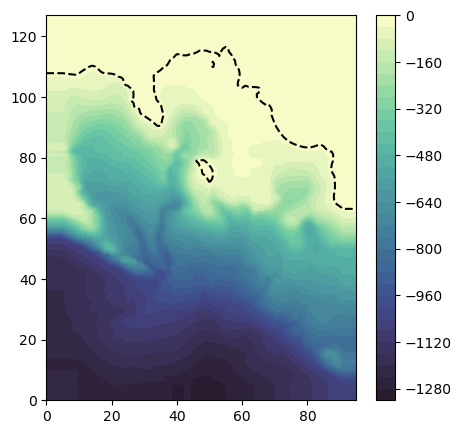

In [11]:
# Check it is read correctly
cc=np.fromfile(bathy_fname, dtype=dt)
np.shape(cc)

bF=np.reshape(cc,[nx,ny],'F') # F to read in Fortran order

fig,ax = plt.subplots(1,1, figsize=(5,5))

pc = ax.contourf(bF, 40, cmap=cmo.cm.deep_r)
plt.colorbar(pc,ax=ax)
ax.contour(bF, levels=[-20,0], colors='k')

Looks weird but it is what MITgcm wants.

### Check x and y origins for data file

In [12]:
lon_vect[0]

-117.1

In [13]:
lat_vect[0]

31.6

In [15]:
np.nanmin(bathy)

-1300.0

In [17]:
1300/26

50.0